# Network Performance Analysis

*Jeff Qiu*   
*Jun 4, 2020*  

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from IPython.display import display, HTML
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size': 15})

## 0. Preperation

Read cvs data into pandas dataframe.

In [2]:
def parse_ping(path, team_no, seq_no):
    names=['service', 'date', 'time', 'pings', 'avg_ping']
    df = pd.read_csv(path, header=0, names=names)
    df['team'] = team_no
    df['seq'] = seq_no
    return df.drop('pings', axis=1)

def parse_tr1(path, team_no, seq_no):
    names=['service','date','time','hop','IP','delay1','delay2','delay3','avg_delay']
    df = pd.read_csv(path, header=0, names=names)
    df['team'] = team_no
    df['seq'] = seq_no
    return df.drop(['delay1', 'delay2', 'delay3'], axis=1)

def parse_pchar1(path, team_no, seq_no):
    names=['service','date','time','hop','IP','delay','package_loss']
    df = pd.read_csv(path, header=0, names=names)
    df['team'] = team_no
    df['seq'] = seq_no
    return df

In [3]:
list_df_ping, list_df_tr1, list_df_pchar1 = [], [], []
for (team_no, seq_no) in tqdm(product(range(1, 9), range(1, 4)), total=24):
    path_prefix = 'data/team{}/seq{}/'.format(team_no, seq_no)
    team_seq_data_paths = os.listdir(path_prefix)
    for filename in team_seq_data_paths:
        path = path_prefix + filename
        tokens = filename.split("_")
        website = tokens[1]
        profiler = tokens[-2]
        if profiler=='ping':
            list_df_ping.append(parse_ping(path, team_no, seq_no))
        elif profiler=='tr1':
            list_df_tr1.append(parse_tr1(path, team_no, seq_no))
        elif tokens[-1]=='pchar1.txt':
            list_df_pchar1.append(parse_pchar1(path, team_no, seq_no))
        else:
            pass
df_ping = pd.concat(list_df_ping, ignore_index=True)
df_tr1 = pd.concat(list_df_tr1, ignore_index=True)
df_pchar1 = pd.concat(list_df_pchar1, ignore_index=True)

100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


## 1. E2E route consistency

### Day-to-day Consistency

Text(0, 0.5, 'log(delay)')

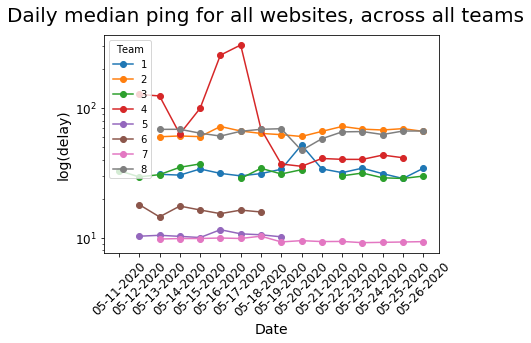

In [4]:
dates = np.unique(df_ping['date'])
ping_agg = df_ping.groupby(['date', 'team'], as_index=False).aggregate(np.median)
fig = plt.figure()
fig.suptitle('Daily median ping for all websites, across all teams', fontsize=20)
for name, group in ping_agg.groupby('team'):
    aligned = group.set_index('date').reindex(dates)
    aligned['team']=name
    plt.plot(aligned['avg_ping'], label=name, marker='o')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
# plt.ylim(20, 400)
plt.legend(title='Team')
plt.xlabel('Date', fontsize=14)
plt.ylabel('log(delay)', fontsize=14)

Day-to-day change in ping latency varies greatly across different locations. The figure above shows the daily average latency for all websites across all teams. There seem to be no pattern in the latency throughout the week for each team, nor correlation between each team.

Text(0, 0.5, 'log(delay)')

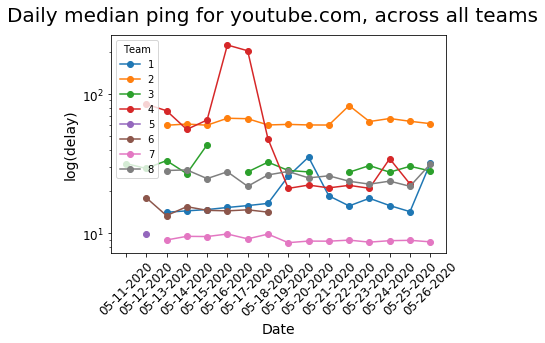

In [5]:
ping_agg_youtube = df_ping[df_ping['service']=='www.youtube.com'].groupby(['date', 'team'], as_index=False).aggregate(np.median)
fig = plt.figure()
fig.suptitle('Daily median ping for youtube.com, across all teams', fontsize=20)
for name, group in ping_agg_youtube.groupby('team'):
    aligned = group.set_index('date').reindex(dates)
    aligned['team']=name
    plt.plot(aligned['avg_ping'], label=name, marker='o')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(title='Team')
plt.xlabel('Date', fontsize=14)
plt.ylabel('log(delay)', fontsize=14)

Latencies for an specific website follow the same pattern as the average latency for all website, with the exception of some outliers such as the spike on 05-21-2020 for team 2 (orange). Together, these two graphs show that the day-to-day latency changes vary, but are consistent across websites.

### Within Day Consistency

In [6]:
def f_agg(pings):
    if len(pings)>1:
        return (pings[1]- pings[0])/pings[0]
    else:
        return 0

d2d_agg = df_ping.groupby(['date', 'team', 'service', 'time'], as_index=False).aggregate(np.mean)
d2d_delta = d2d_agg.groupby(['date', 'team', 'service'], as_index=False)['avg_ping'].aggregate(f_agg)
avg_delta = d2d_delta.groupby(['team', 'service'], as_index=False).aggregate(np.mean).pivot('service', 'team')
avg_delta = avg_delta.replace(0.0, np.nan)*100
avg_delta

avg_ping                                              \
team                            1          2          3          4          5   
service                                                                         
en.wikipedia.org        -9.446536  13.591721   4.983239  17.120374        NaN   
www.amazon.com          -7.556468   2.562872  13.657170   2.787292        NaN   
www.amazon.de           -7.469985  -6.940514   5.190368   6.314313        NaN   
www.bbc.co.uk           -8.981752   7.304668   1.600459  -8.786284        NaN   
www.chicagotribune.com        NaN  -3.273762  11.951413        NaN        NaN   
www.cnn.com            -11.015818   9.381439   4.468401   3.171706 -10.648535   
www.etsy.com            -9.362941  -3.449538   3.722577  11.750758  -2.842874   
www.facebook.com         1.067405   5.904532   5.864054  10.328642   4.515366   
www.fda.gov            -14.160103  -0.764660   7.392681  -8.137861  -7.846754   
www.inquirer.com              NaN        NaN        NaN   3.366951        NaN   
www.letgo.com          -10.639103   5.326559   2.174185   1.225844  14.491853   
www.mayoclinic.org            NaN        NaN        NaN  30.107534        NaN   
www.medlineplus.gov    -12.652049   5.431533   6.274891        NaN  -2.207918   
www.nypost.com         -11.445343        NaN        NaN        NaN        NaN   
www.orange.fr           -6.073833   4.952956   1.522514  -2.620858  -0.764378   
www.reddit.com          -9.280538  -0.808592   9.751864  12.609524        NaN   
www.twitter.com         -3.834286   0.903944   2.728306  -4.367310  -7.527990   
www.walmart.com         -0.380576  -5.527745  14.795064   8.606124        NaN   
www.webmd.com           -5.221546  -1.519916  24.202542  17.967262 -11.139692   
www.whitehouse.gov      -2.056933  -4.351651  10.598244   6.149810  -1.410824   
www.wikipedia.jp        -3.188676   3.465396   2.880082   3.077263        NaN   
www.youtube.com         40.512417   5.791310  -4.897639  22.617745   3.642817   

                                                         
team                            6          7          8  
service                                                  
en.wikipedia.org        -0.925702   0.919831  22.038107  
www.amazon.com          17.938332   4.143773  14.984595  
www.amazon.de            3.636382   2.906605  20.478990  
www.bbc.co.uk           -3.698089  -1.702396  -0.625740  
www.chicagotribune.com  -5.301509   3.860083   0.256249  
www.cnn.com             -2.206170   2.124952  -2.077408  
www.etsy.com             5.673962  10.421331   5.728576  
www.facebook.com         0.263072   2.662436  -2.107585  
www.fda.gov             11.338329   5.441364  -5.851021  
www.inquirer.com              NaN        NaN        NaN  
www.letgo.com           -2.281319   3.094897   1.248400  
www.mayoclinic.org            NaN        NaN        NaN  
www.medlineplus.gov    -20.956342   4.841941  20.330096  
www.nypost.com                NaN        NaN        NaN  
www.orange.fr            5.993477   0.126850   1.932867  
www.reddit.com          -1.483550   6.174734  53.319698  
www.twitter.com          0.322495  -0.711429  10.400244  
www.walmart.com         -2.675095   4.888402   9.250499  
www.webmd.com           -3.086512   0.188178  11.778491  
www.whitehouse.gov       8.191888   4.064428   6.993680  
www.wikipedia.jp        -6.497341  -1.788781  -0.119910  
www.youtube.com          4.070729   0.963359  -4.161596

In [7]:
avg_delta.apply([np.mean, np.std])

avg_ping                                                               \
              1         2         3          4         5         6         7   
mean  -4.799298  1.998976  6.782127   7.015202 -1.976266  0.437739  2.769503   
std   11.739972  5.498555  6.371932  10.176029  7.562858  8.044558  3.023970   

                 
              8  
mean   8.620907  
std   13.852602

In [8]:
avg_delta.apply([np.mean, np.std], axis=1).transpose()

,en.wikipedia.org,www.amazon.com,www.amazon.de,www.bbc.co.uk,www.chicagotribune.com,www.cnn.com,www.etsy.com,www.facebook.com,www.fda.gov,www.inquirer.com,...,www.medlineplus.gov,www.nypost.com,www.orange.fr,www.reddit.com,www.twitter.com,www.walmart.com,www.webmd.com,www.whitehouse.gov,www.wikipedia.jp,www.youtube.com
mean,6.897291,6.931081,3.445166,-2.127019,1.498495,-0.850179,2.705231,3.562240,-1.573503,3.366951,...,0.151736,-11.445343,0.633699,10.040449,-0.260753,4.136668,4.146101,3.52233,-0.310281,8.567393
std,11.152613,8.992305,9.387566,5.760301,6.808052,7.178271,7.315855,3.919595,8.913349,NaN,...,13.598954,NaN,3.921655,20.487904,5.437145,7.308674,12.381014,5.45874,3.757142,15.451447


The statistics above measures the mean and standard deviation of percentage change between two daily measurements, aggregated through all days, and then through all websites or all locations. The large ratio of standard deviation to mean shows that the changes are rather inconsistent: greater spreads means that the percentage changes within a day for a website/location combinition are more diverse. However, a comparison of the statistics between website aggregation and location aggregation shows that the inconsistency may be location/website specific, since some location/websites clearly has larger spread than others.

## 2. Network bottleneck 

In [9]:
# def process_ip(df):
df_tr1['IP_'] = df_tr1['IP'].apply(lambda x: x[1:-1])
df_pchar1['IP_processed'] = df_pchar1['IP'].apply(lambda x: '.'.join(x.split('.')[:2]))
df_tr1['IP_processed'] = df_tr1['IP'].apply(lambda x: '.'.join(x.split('.')[:2]))

In [10]:
from scipy import stats
def highlight_mode(s):
    is_mode = s == stats.mode(s).mode[0]
    return ['background-color: yellow' if v else '' for v in is_mode]

def print_bottleneck(df, service, val_col='IP', sort_col='delay'):
    grouped = df.groupby(['service', 'date', 'team'], as_index=False)
    max_delay = grouped.apply(lambda df: df.sort_values(sort_col, ascending=False)
                                           .drop_duplicates(['service', 'date', 'team']))
    max_delay_service = max_delay.query("service=='{}'".format(service))
    bottleneck = max_delay_service.pivot(index='date', columns='team', values=val_col)
    display(bottleneck.style.apply(highlight_mode))

In [11]:
print_bottleneck(df_pchar1, 'www.youtube.com', val_col='IP')

team,1,2,3,4,5,6,7,8
date,,,,,,,,
05-11-2020,nan,nan,96.120.53.49,nan,nan,nan,nan,nan
05-12-2020,nan,nan,96.110.42.233,96.120.74.249,96.120.26.81,74.125.251.183,nan,nan
05-13-2020,10.0.0.1,108.170.249.98,96.120.53.49,192.168.86.1,nan,96.120.26.81,96.120.25.13,96.120.90.5
05-14-2020,10.0.0.1,96.34.90.15,172.217.6.110,68.85.35.37,nan,nan,162.151.37.25,96.120.90.5
05-15-2020,64.246.129.219,96.34.0.164,96.110.42.229,96.120.74.249,nan,nan,96.120.25.13,96.120.90.5
05-16-2020,64.246.129.219,192.168.4.1,nan,68.86.223.249,nan,nan,96.110.40.49,96.120.90.5
05-17-2020,10.0.0.1,192.168.4.1,192.168.86.1,216.239.42.167,nan,nan,72.14.239.123,68.86.248.253
05-18-2020,10.0.0.1,96.34.0.164,216.58.192.206,192.168.86.1,nan,nan,209.85.240.245,96.120.90.5
05-19-2020,64.246.129.219,96.34.0.33,96.110.42.229,96.120.74.249,nan,nan,108.170.230.146,96.120.90.5


In [12]:
print_bottleneck(df_tr1, 'www.youtube.com', val_col='IP_',sort_col='avg_delay')

team,1,2,3,4,5,6,7,8
date,,,,,,,,
05-11-2020,nan,nan,66.208.229.70,nan,nan,nan,nan,nan
05-12-2020,nan,nan,74.125.251.183,172.217.10.14,216.239.47.129,108.170.230.146,nan,nan
05-13-2020,64.246.129.73,216.239.59.153,142.250.58.193,69.241.68.158,nan,209.85.255.173,96.110.40.57,209.85.251.9
05-14-2020,64.246.129.219,142.250.58.193,96.110.190.113,172.253.72.117,nan,96.110.40.57,108.170.238.139,96.108.99.13
05-15-2020,108.170.248.1,108.170.249.162,108.170.231.195,68.85.35.37,nan,96.87.9.226,162.151.37.25,209.85.251.9
05-16-2020,64.246.129.219,209.85.246.249,nan,69.241.68.158,nan,96.110.40.57,96.110.40.49,96.108.99.13
05-17-2020,172.217.12.142,108.170.233.87,108.170.233.87,172.253.69.211,nan,96.110.40.53,162.151.37.25,68.85.57.233
05-18-2020,142.250.46.197,72.14.233.11,108.170.243.174,68.85.35.37,nan,68.86.184.253,162.151.37.25,68.86.248.253
05-19-2020,192.170.192.42,142.250.58.187,96.110.42.233,68.85.35.37,nan,nan,96.110.40.53,96.112.146.18


The function `print_bottleneck(df, service)` prints the bottleneck for a given service on each day of each team's measurement, measured by the hop with longest delay. In the tables above, we processed the ip address to contain only the first two segment of the address, and highlight the most common bottleneck in all measurement. We outline several observations from the bottlenecks for youtube.com, extracted from pchar and traceroute: 
- First, the results from traceroute and pchar are inconsistent with each other. None of the teams have the same bottleneck from traceroute and pchar, which may be caused by different measurement approach causing different routes.
- Second, comparing the results within 2 weeks, most teams seem to have bottlenecks coming from 2-3 specific ip range, and some have the extact same ip addresses. In addition, bottlenecks extracted from pchar seem to be more consistent than traceroute within 2 weeks. 
- Third, both results seem to show that more than half of bottlenecks coming from a specific ip range, beginning with `96`. However, after manually looking up these addresses on ARIN, we could only find that they are allocated to Comcast, and the geographical location for these addresses vary from California to Virginia. We do not know what cause the pattern.
